In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [65]:
orders = pd.read_csv('/home/jupyter-l.fedoseeva-12/products_analytics/Lesson_4_Segmentation/Project=DZ/RFM_ht_data.csv',sep=',')

/opt/tljh/user/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [66]:
orders.shape

(332730, 4)

In [67]:
orders.head()

,InvoiceNo,CustomerCode,InvoiceDate,Amount
0,C0011810010001,19067290,2020-09-01,1716.00
1,C0011810010017,13233933,2020-09-01,1489.74
2,C0011810010020,99057968,2020-09-01,151.47
3,C0011810010021,80007276,2020-09-01,146.72
4,C0011810010024,13164076,2020-09-01,104.00


In [98]:
orders.dtypes

InvoiceNo               object
CustomerCode            object
InvoiceDate     datetime64[ns]
Amount                 float64
dtype: object

In [96]:
orders['InvoiceDate'] = pd.to_datetime(orders['InvoiceDate'])

In [97]:
orders['CustomerCode'] = orders['CustomerCode'].apply(str)

In [99]:
orders['InvoiceNo'] = orders['InvoiceNo'].apply(str)

In [70]:
orders['InvoiceDate'].describe()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                  332730
unique                     30
top       2020-09-30 00:00:00
freq                    19781
first     2020-09-01 00:00:00
last      2020-09-30 00:00:00
Name: InvoiceDate, dtype: object

In [71]:
last_date = orders['InvoiceDate'].max()
last_date

Timestamp('2020-09-30 00:00:00')

Какое максимальное кол-во покупок было совершено одним пользователем?

In [103]:
max_orders = orders.groupby('CustomerCode') \
        .agg({'InvoiceNo' : 'count'})

In [104]:
max_orders.max()

InvoiceNo    204
dtype: int64

In [105]:

rfmTable = orders.groupby('CustomerCode').agg({'InvoiceDate': lambda x: (last_date - x.max()).days, # Recency #Количество дней с последнего заказа
                                        'InvoiceNo': lambda x: len(x),      # Frequency #Количество заказов
                                        'Amount': lambda x: x.sum()}) # Monetary Value #Общая сумма по всем заказам

rfmTable['InvoiceDate'] = rfmTable['InvoiceDate'].astype(int)
rfmTable.rename(columns={'InvoiceDate': 'recency', 
                         'InvoiceNo': 'frequency', 
                         'Amount': 'monetary_value'}, inplace=True)

In [106]:
rfmTable

,recency,frequency,monetary_value
CustomerCode,,,
02213019,19,1,1609.20
02213042,22,3,9685.48
02213071,29,1,415.00
02213088,23,1,305.00
02213092,25,1,1412.88
...,...,...,...
99099927,10,1,961.10
99099936,0,1,1521.78
99099959,8,2,1444.56


In [107]:
rfmTable.shape

(123733, 3)

In [108]:
orders['CustomerCode'].nunique()

123733

In [109]:
quantiles = rfmTable.quantile(q=[0.25,0.5,0.75])

In [110]:
quantiles

,recency,frequency,monetary_value
0.25,2.0,1.0,765.00
0.50,8.0,2.0,1834.48
0.75,16.0,3.0,4008.84


In [111]:
rfmSegmentation = rfmTable

In [112]:

def RClass(value,parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 1
    elif value <= quantiles_table[parameter_name][0.50]:
        return 2
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 3
    else:
        return 4


def FMClass(value, parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 4
    elif value <= quantiles_table[parameter_name][0.50]:
        return 3
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 2
    else:
        return 1

In [113]:

rfmSegmentation['R_Quartile'] = rfmSegmentation['recency'].apply(RClass, args=('recency',quantiles))

rfmSegmentation['F_Quartile'] = rfmSegmentation['frequency'].apply(FMClass, args=('frequency',quantiles))

rfmSegmentation['M_Quartile'] = rfmSegmentation['monetary_value'].apply(FMClass, args=('monetary_value',quantiles))

rfmSegmentation['RFMClass'] = rfmSegmentation.R_Quartile.map(str) \
                            + rfmSegmentation.F_Quartile.map(str) \
                            + rfmSegmentation.M_Quartile.map(str)

In [114]:
rfmSegmentation.head()

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
CustomerCode,,,,,,,
02213019,19,1,1609.20,4,4,3,443
02213042,22,3,9685.48,4,2,1,421
02213071,29,1,415.00,4,4,4,444
02213088,23,1,305.00,4,4,4,444
02213092,25,1,1412.88,4,4,3,443


Какая верхняя граница у суммы покупок у пользователей с классом 4 в подсегменте М? (Другими словами: пользователи, у которых сумма покупок от 0 до Х попадают в 4 класс в подсегменте М)

In [119]:
rfmSegmentation.query('M_Quartile == 4') \
                .agg({'monetary_value' : 'max'})

monetary_value    765.0
dtype: float64

Какая нижняя граница у количества покупок у пользователей с классом 1 в подсегменте F?

In [120]:
rfmSegmentation.query('F_Quartile == 1') \
                .agg({'frequency' : 'min'})

frequency    4
dtype: int64

Какое максимальное количество дней может пройти с момента последней покупки для того, чтобы пользователь попал в класс 2 в подсегменте R?

In [121]:
rfmSegmentation.query('R_Quartile == 2') \
                .agg({'recency' : 'max'})

recency    8
dtype: int64

Сколько пользователей попало в сегмент 111?

In [128]:
rfmSegmentation.RFMClass.value_counts()

444    10624
111     9705
443     6729
344     6593
211     5847
       ...  
424       63
214       60
114       60
314       33
414        2
Name: RFMClass, Length: 64, dtype: int64

Сколько пользователей попало в сегмент 311?

In [134]:
rfmSegmentation.query('R_Quartile == 3 & F_Quartile == 1 & M_Quartile == 1').count()

recency           1609
frequency         1609
monetary_value    1609
R_Quartile        1609
F_Quartile        1609
M_Quartile        1609
RFMClass          1609
dtype: int64

В каком RFM-сегменте самое большое кол-во пользователей?

In [141]:
rfmSegmentation.RFMClass.value_counts().idxmax()

'444'

В каком RFM-сегменте самое маленькое кол-во пользователей?

In [142]:
rfmSegmentation.RFMClass.value_counts().idxmin()

'414'

Какое количество пользователей попало в самый малочисленный сегмент?

In [143]:
rfmSegmentation.RFMClass.value_counts().min()

2

In [115]:
pd.crosstab(index = rfmSegmentation.R_Quartile, columns = rfmSegmentation.F_Quartile)

F_Quartile,1,2,3,4
R_Quartile,,,,
1,14433,4671,5795,6074
2,9634,5889,8633,10399
3,3091,3748,7734,13263
4,542,1311,5415,23101


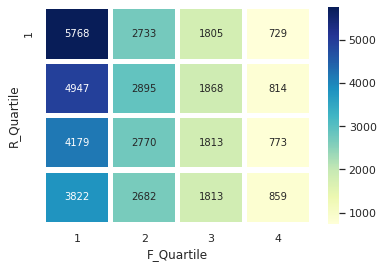

In [144]:

rfm_table = rfmSegmentation.pivot_table(
                        index='R_Quartile', 
                        columns='F_Quartile', 
                        values='monetary_value', 
                        aggfunc=np.median).applymap(int)
sns.heatmap(rfm_table, cmap="YlGnBu", annot=True, fmt=".0f", linewidths=4.15, annot_kws={"size": 10},yticklabels=4);